**Note**: this notebook uses the `streetmapper` library, which may have changed since time of writing. To regenerate the datasets, use the version of this library as of commit [`72c332`](https://github.com/ResidentMario/streetmapper/tree/72c3321d92e10db96e2f0b14f232b679e8778b6c).

This notebook is a development restart of the `streetmapper` library and the `trash-talk` project.

## Preprocessing

### Linking block, building, blockface, and frontages

The central problem in analyzing point GPS data is that it is disconnected from its surrounding geospatial context. We need to assign the trash point data to the block it is located on, and the building on that block it is closest to. This first section of this notebook performs this work, using functions from the `streetmapper` library, which was purpose-developed for this project.

In [1]:
import pandas as pd
import geopandas as gpd

# geospatial dataset of building footprints
buildings = gpd.read_file("../../data/Building Footprints").to_crs({"init": "epsg:4326"})

# geospatial dataset of street centerlines
# streets = gpd.read_file("../../data/Streets - Active and Retired.geojson")

# geospatial dataset of blocks
blocks = gpd.read_file("../../data/Census 2010_ Blocks for San Francisco.geojson")

In [2]:
%load_ext autoreload
%autoreload 2

import streetmapper as sm

First, use `blockfaces_on_blocks` to generate a `DataFrame` of `blockfaces`. Blockfaces are generated using the following algorithm (comment from the code):

> We pass a simplification algorithm over the block geometry and examine the points which survive in order to determine which points are geometrically important to the block geometry. These points form the boundaries of the blockfaces we partition the block into. Points not included in the simplified geometry become intermediate points along the blockface boundary.


A simple rectangular block will have four blockfaces, one for each side of the block. More complex blocks may have any number of blockfaces, subject to the shape complexity of the block.

In [3]:
%time blockfaces = sm.blockfaces_on_blocks(blocks, blocks_uid_col='geoid10')

CPU times: user 17.8 s, sys: 213 ms, total: 18.1 s
Wall time: 18.3 s


In [4]:
blockfaces.columns = ['blockface_id', 'block_id', 'geometry']

The resulting `DataFrame` contains the segment of the block geometry selected as the blockface, the original `block_id` of the parent block, and a new `blockface_id` ID unique to the indiviudal blockface that is based on the parent `block_id`.

In [5]:
blockfaces.head()

,blockface_id,block_id,geometry
0,060750213002002_1,060750213002002,"LINESTRING (-122.440616 37.750902, -122.440459..."
1,060750213002002_2,060750213002002,"LINESTRING (-122.440459 37.749301, -122.441538..."
2,060750213002002_3,060750213002002,"LINESTRING (-122.441538 37.74923100000001, -12..."
3,060750213002002_4,060750213002002,"LINESTRING (-122.441687 37.75083600000001, -12..."
0,060750213002000_1,060750213002000,"LINESTRING (-122.438397 37.750226, -122.43832 ..."


Next we assign buildings to blocks. The docstring for this function is:

> Matches buildings to blocks and returns the result.
>
> This function returns a three-element tuple: `matches` for buildings uniquely joined to blocks, `multimatches` for buildings joined to multiple blocks, and `nonmatches` for buildings joined to no blocks.

Multimatches and non-matches are not a problem in the survey zone, so we take just the `matches` component of the output.

In [6]:
%%time

buildings, _, _ = sm.bldgs_on_blocks(buildings, blocks, buildings_uid_col='globalid')

CPU times: user 1min 4s, sys: 1.39 s, total: 1min 6s
Wall time: 1min 6s


Clean up the names of the columns in the `building` `DataFrame` a bit...

In [7]:
buildings = (
    buildings.assign(
        building_id=buildings.globalid.map(lambda v: v[1:-1].replace('-', '_')), 
        block_id=buildings.geoid10
    )
    .drop(['geoid10', 'globalid'], axis='columns')
)

In [8]:
blocks = blocks.rename(columns={'geoid10': 'block_id'})

In [9]:
buildings.head()

,area_id,cells50cm_,gnd1st_del,gnd_cells5,gnd_majori,gnd_maxcm,gnd_meancm,gnd_median,gnd_min_m,gnd_mincm,...,blockce10,awater10,funcstat10,aland10,tractce10,intptlon10,ur10,countyfp10,building_id,block_id
0,1.0,178250.0,9.09,178250.0,643.0,704.0,595.642771,600.0,5.07,507.0,...,1134,0,S,210383,980900,-122.3809075,None,075,CF7EF595_68E6_4950_B361_CC82D77383A0,060759809001134
4,5.0,102761.0,10.70,102761.0,109.0,422.0,196.438970,154.0,0.81,81.0,...,1001,0,S,116249,010500,-122.3990586,None,075,EF68C9FB_598E_44B7_88FF_0B60B08CD896,060750105001001
5,6.0,99724.0,14.12,99724.0,685.0,718.0,675.857065,683.0,5.75,575.0,...,2040,0,S,35142,017700,-122.4142837,None,075,92730D93_A833_41DA_B823_342B4DB4F5FC,060750177002040
6,7.0,93580.0,10.93,93580.0,914.0,1311.0,984.630487,972.0,8.83,883.0,...,1007,0,S,83992,026403,-122.4097639,None,075,AB041BD2_DE81_4230_9AE5_38D5A06021D1,060750264031007
7,8.0,91973.0,14.38,91973.0,348.0,400.0,326.994868,332.0,2.36,236.0,...,1002,0,S,441831,980900,-122.3815054,None,075,9EE3DC7C_7992_4E17_9C4B_32426607E057,060759809001002


We are not interested in *all* buildings and *all* blocks, just those that lie within the survey zone, along the survey axis. This requires manually selecting just the buildings adjacent to the survey area.

I used [`geojson.io`](http://geojson.io/#map=17/37.79809/-122.42389) to construct the following simple polygons encapsulating the survey zone:

In [10]:
from shapely.geometry import Polygon

bldg_selection_area = Polygon([[
      -122.42260694503784,
      37.79583908920013
    ],
    [
      -122.42072939872742,
      37.79609342639563
    ],
    [
      -122.42158770561217,
      37.79983208212613
    ],
    [
      -122.42346525192261,
      37.79959471278463
    ],
    [
      -122.42260694503784,
      37.79583908920013
]])

block_selection_area = Polygon([[
      -122.42069721221922,
      37.80017965728568
    ],
    [
      -122.4207615852356,
      37.80013727015868
    ],
    [
      -122.4251925945282,
      37.799696442595824
    ],
    [
      -122.42442011833191,
      37.79545758176509
    ],
    [
      -122.41987109184265,
      37.79600016952563
    ],
    [
      -122.42069721221922,
      37.80017965728568
]])

# uncomment these lines to see this selection zone)(s) on a webmap
# import geoplot as gplt
# import mplleaflet
# ax = gplt.polyplot(gpd.GeoDataFrame([], geometry=[bldg_selection_area]))
# gplt.polyplot(gpd.GeoDataFrame([], geometry=[block_selection_area]), ax=ax)
# mplleaflet.show()

In [11]:
blocks_of_interest = sm.select_area_of_interest(blocks, block_selection_area)
buildings_of_interest = sm.select_area_of_interest(buildings, bldg_selection_area)

In [12]:
len(blocks_of_interest)

13

We need to further process `blocks_of_interest` to remove the street island blocks on either side of the block set:

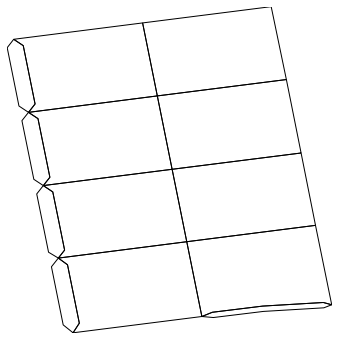

In [15]:
# further processing to remove "street island blocks"
import geoplot as gplt
%matplotlib inline
gplt.polyplot(blocks_of_interest)

These blocks are actually traffic control features. There is a pedestrian island on Broadway (the street below), and there is some traffic line splitting on Van Ness (the street to the left) that apparently the city is including as "blocks" in the dataset.

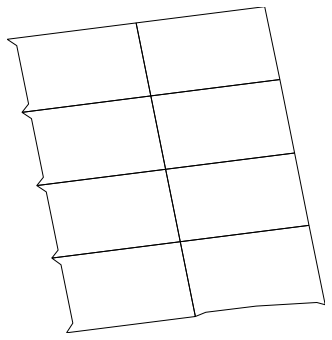

In [16]:
gplt.polyplot(blocks_of_interest.iloc[[1, 6, 7, 8, 9, 10, 11, 12]])

In [17]:
blocks_of_interest = blocks_of_interest.iloc[[1, 6, 7, 8, 9, 10, 11, 12]]

In [18]:
len(blocks_of_interest)

8

In [19]:
len(buildings_of_interest)

137

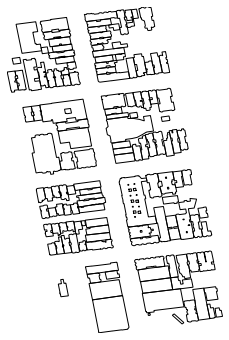

In [20]:
gplt.polyplot(buildings_of_interest)

Again, we need to filter this down to just the buildings that are located along the street centerline. However because there are many more buildings than there are blocks, this is a much more tedious operation. So we'll approach it in two steps. For now, we'll use this superset of buildings of interest in the frontage assignment algorithm that follows. Later on, we'll select just the blockfaces we care about (were this analysis productionized, this is what a user would do in an app), and exclude all buildings that don't have any frontages attached to those blockfaces.

At this point we have:

* A relevant subselection of blocks from the survey zone.
* A relevant subselection of buildings from the survey zone.
* Blockfaces for every block in the city.

We can assign each building in our sub-selection to a frontage: a stretch of a blockface that is nearest to a building. Thus buildings have a 1-to-N relationship to frontages (a single building many have many frontages), which have an N-to-1 relationship to blockfaces (a blockface may have multiple frontages, each one belonging to a specific chunk of the blockface), which have an N-to-1 relationship to blocks (a block has multiple blockfaces).

In [99]:
%%time

frontages_of_interest = sm.frontages_on_blockfaces(
    blocks_of_interest, blockfaces, buildings_of_interest,
    blocks_uid_col='block_id',
    buildings_uid_col='building_id',
    blockfaces_block_uid_col='block_id', 
    buildings_block_uid_col='block_id',
    step_size=0.01
)

100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


CPU times: user 1.58 s, sys: 32.7 ms, total: 1.61 s
Wall time: 1.65 s


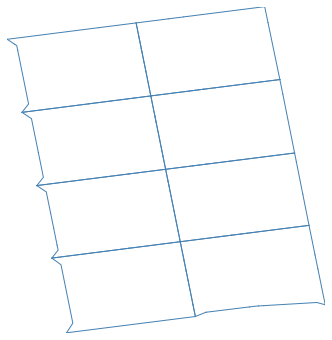

In [100]:
gplt.sankey(frontages_of_interest)

Our survey zone is just the four streets on Polk. We filter to just those segments:

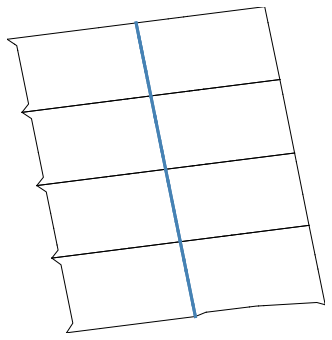

In [101]:
frontage_selection_area = Polygon(
          [
            [
              -122.4227786064148,
              37.79978969479967
            ],
            [
              -122.42189884185791,
              37.79557627317823
            ],
            [
              -122.42151260375975,
              37.795618662922415
            ],
            [
              -122.4223494529724,
              37.79985751451035
            ],
            [
              -122.4227786064148,
              37.79978969479967
            ]
          ]

)

extent = frontages_of_interest.total_bounds
ax = gplt.sankey(frontages_of_interest, color='black')
frontages_of_interest = sm.select_area_of_interest(frontages_of_interest, frontage_selection_area)
frontages_of_interest = (frontages_of_interest
 .reset_index(drop=True)
 .iloc[[v for v in range(len(frontages_of_interest)) if v not in [26, 43]]]
 .reset_index(drop=True)
)
gplt.sankey(frontages_of_interest, ax=ax, extent=extent, linewidth=3)

Recall that we have not completely filtered the buildings. With the frontages we care about selected, we can now easily back up back to the buildings:

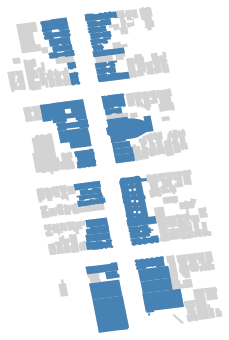

In [102]:
extent = buildings_of_interest.total_bounds
ax = gplt.polyplot(buildings_of_interest, edgecolor='None', facecolor='lightgray')
buildings_of_interest =\
    buildings_of_interest[buildings_of_interest['building_id'].isin(frontages_of_interest['building_id'])]
gplt.polyplot(buildings_of_interest, edgecolor='None', facecolor='steelblue', ax=ax, extent=extent)

**TODO**: redress the four buildings that should have been included, but weren't.

At this point we have all the geometries we need.

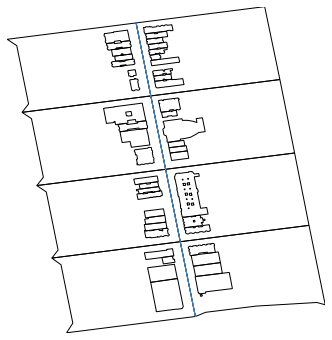

In [103]:
ax = gplt.polyplot(buildings_of_interest)
gplt.sankey(frontages_of_interest, ax=ax)
gplt.polyplot(blocks_of_interest, ax=ax)

This `GeoDataFrame` samples shows how the relationship between frontage (unique ID `frontage_id`, which is derived from `building_id`) and `blockface_id` (and from there, `building_id` and `block_id`) is encoded. Each blockface is divided into `n` frontages, each of which is responsible for a certain subsegment of the blockface. The exact span is that encoded by the `geom_offset_end` and `geom_offset_start` values, where 0 is the position of the first point in the blockface and 1 is the position of the last, relative to the total length of the blockface line. Offsets are rounded to the nearest .01 due to how this operation is implemented.

### Adding contextual information

Everything we have done so far has been automated parsing, now it's time to add some human-generated information into the mix. There is limited information that we can gather about our features of interest in an automated manner in the scope of this project. We instead opted to gather certain types of rich contextual information manually. These are:

* The types of businesses in the building, e.g. barber, bar, corner store, etc.
* The average Yelp rating of those businesses.
* The average Yelp \$ rating of those businesses.

In [ ]:
len(buildings_of_interest)

In [ ]:
import mplleaflet
gplt.polyplot(buildings_of_interest.iloc[[46]])
mplleaflet.show()

In [ ]:
import numpy as np

# notes: including "bagels stores" under "bakery".
# indexed per-building and constructed by hand
building_class_data =\
{
    '5D4F4266_20D0_4676_B7ED_6D0E64DD92BF': [
        ['Cole Hardware', 'Fiorella Polk', 'Philz Coffee', 'The Boy\'s Deli', 'Polk & Green Produce Market'],
        ['Hardware Store', 'Pizza Shop', 'Coffee Shop', 'Convenience Store', 'Supermarket'],
        [4.5, 4, np.nan, np.nan, 4.5, 1],
        [2, np.nan, np.nan, 4, 2]
    ],
    # the below was formerly the building occuped by Escape from New York, which was very dirty
    '561F8CF4_1948_443E_BB07_14D9481FF5B9': [
        ['Teaspoon San Francisco', 'MAC\'D', 'Nick\'s Crispy Tacos', 'Rogue Night Club'],
        ['Bubble Tea', 'Restaurant', 'Nightclub'],
        [4, 4, 4, 2.5],
        [1, 1, 1, 2]
    ],
    '31780D91_F8DE_42C8_8F19_0C383DA4859C': [
        ['Crunch Fitness'],
        ['Gym'],
        [3],
        [np.nan]
    ],
    'D99FD788_E73D_44D6_9877_1742C12E5DC1': [
        ['Residential'],
        ['Residential'],
        [np.nan],
        [np.nan]
    ],
    '4BC908C6_542E_4BEC_9E5A_85C6FC9D5AC4': [
        ['Walgreen\'s'],
        ['Convenience Store', 'Pharmacy'],
        [3.5],
        [1]
    ],
    'D0C1A69D_B035_41B9_AE6E_D34A9B394393': [
        ['Lemongrass Thai Cuisine', 'Saint Frank Coffee'],
        ['Restaurant', 'Coffee Shop'],
        [3.5, 4.5],
        [2, 1]
    ],
    'D32097DD_5E72_4125_8BB1_8590C4CFFB33': [
        ['Street Restaurant and Bar', 'Peet\'s Coffee', 'Bagelry'],
        ['Restaurant', 'Bar', 'Coffee Shop', 'Bakery'],
        [4, 4, 3.5],
        [2, 1, 1]
    ],
    'D11DE3ED_DA84_49B5_928F_088942F1027D': [
        ['Bow Wow Meow SF', 'Russian Hill Bookstore'],
        ['Pet Store', 'Bookstore'],
        [3.5, 4],
        [np.nan, 2]
    ],
    '2311A996_5CDB_40AB_AD60_7AFE98A2E81D': [
        ['Backstage Salon', 'Real Food Company'],
        ['Salon', 'Grocery Store'],
        [4.5, 2],
        [3, 3]
    ],
    '2E3DF4D4_6266_4632_9318_82315E036985': [
        ['Belso Home & Garden by FL!PP'],
        ['Home Decor'],
        [5],
        [2]
    ],
    '8127AC2E_1D16_4781_AE54_DA60A5A2E215': [
        ['Best Choice Cleaners'],
        ['Laundromat'],
        [4],
        [1]
    ],
    '1AE9E9B8_DAC9_4B02_9D32_D90DACADB4CB': [
        ['Loving Cup', 'No.3'],
        ['Coffee Shop', 'Jewelry Store'],
        [4, 1],
        [5, 3]
    ],
    'C5CC6D88_2842_48DE_B1A2_44D996DE3C78': [
        ['Vacant'],
        ['Vacant'],
        [np.nan],
        [np.nan]
    ],
    '1CB6F0E0_0CEA_4743_9A2C_4ED9BEA24A68': [
        ['Starbucks'],
        ['Coffee Shop'],
        [2.5],
        [1]
    ],
    '574509F5_F656_4291_92F5_4B043728E61D': [
        ['Royal Ground Coffee'],
        ['Coffee Shop'],
        [4],
        [1]
    ],
    'D21D498F_0976_44E3_B9B7_67D355ED7DF8': [
        ['Polk Street Cleaners'],
        ['Laundromat'],
        [3],
        [2]
    ],
    '5423D79A_34D5_41C3_9B7A_2E4E5949BCF5': [
        ['Leopold\'s'],
        ['Restaurant'],
        [4.5],
        [2]
    ],
    'C84A3FBA_F146_4A30_A2D7_FA9892831308': [
        ['Best Choice Cleaners'],
        ['Laundromat'],
        [4],
        [2]
    ],
    'C64D3FDB_CF39_412F_BDF9_C1C3867738E1': [
        ['Royal Oak', 'Sugar Society SF'],
        ['Bar', 'Spray Tanning'],
        [3, 5],
        [2, 2]
    ],
    'A72E4092_C2AD_411D_9A56_CDD2DDDABB84': [
        ['Vacant'],
        ['Vacant'],
        [np.nan],
        [np.nan]
    ],
    '034904B1_6E6D_4FE3_BCB3_5DF151831DE5': [
        ['Les Cent Culottes'],
        ['Lingerie Store'],
        [4],
        [3]
    ],
    'A3D97542_0E4C_4FC9_A8B9_FFD503B7982E': [
        ['Tulip Salon'],
        ['Salon'],
        [4.5],
        [2]
    ],
    'FCC0D9EB_D614_4055_A3A3_DB3D904B959F': [
        ['Cresta\'s Twenty Two Eleven Club', 'Bullitt'],
        ['Bar', 'Bar'],
        [4.5, 3],
        [1, 2]
    ],
    '20310060_D1C6_4715_84BC_70AA48DE916A': [
        ['Woods Polk Station', 'Project Juice'],
        ['Bar', 'Juice and Smoothie Bar'],
        [4, 2],
        [2, 2]
    ],
    '79B34F88_1AE9_4AB3_96FB_C4661FE8CEA1': [
        ['Optical Works Eyewear'],
        ['Optician'],
        [5],
        [2]
    ],
    '4CC39306_F6E9_4071_9E16_4DB10BED0D05': [
        ['Split'],
        ['Restaurant'],
        [3.5],
        [2]        
    ],
    '160C3C1F_347E_480A_B890_130B43C7A97D': [
        ['Smoke Signals', 'House Rules'],
        ['Cigar Shop', 'Bar'],
        [5, 4],
        [2, 2]        
    ],
    '3904CC8B_AB17_4571_9318_7F5E6B4E6D3A': [
        ['Residential'],
        ['Residential'],
        [np.nan],
        [np.nan]
    ],
    '685BC04F_97DC_492E_B6F5_487FC054B4BE': [
        ['Blue Barn'],
        ['Restaurant'],
        [4],
        [2]
    ],
    'C04E26FB_B8AD_4DC2_AA57_2D26CC20F479': [
        ['Residential'],
        ['Residential'],
        [np.nan],
        [np.nan]
    ],
    '48D0D3C4_BBA4_4FB0_9BB0_9F03D0A1117D': [
        ['Residential'],
        ['Residential'],
        [np.nan],
        [np.nan]
    ],
    'DD6801D5_4B09_4995_8625_175D5A39707F': [
        ['Residential'],
        ['Residential'],
        [np.nan],
        [np.nan]        
    ],
    '504D27C7_8110_45EA_960F_CC1965FBB564': [
        ['Greens Sports Bar'],
        ['Bar'],
        [3.5],
        [1]
    ],
    'B6110223_D173_4463_8DEB_2FDA83536EA0': [
        ['La Folie'],
        ['Wine Bar'],
        [4.5],
        [4]
    ],
    'E8EDE761_E216_43BA_A035_BF797CAE87CC': [
        ['Cocoon Bare'],
        ['Salon'],
        [4.5],
        [2]        
    ],
    '7698EF27_E3CF_47EE_B096_8F04C4FAB369': [
        ['William Cross Wine Merchants & Wine Bar'],
        ['Alcohol Store', 'Wine Bar'],
        [4.5],
        [2]
    ],
    'CDF0835C_E84F_49E2_93B2_F506EDEA7636': [
        ['Vacant'],
        ['Vacant'],
        [np.nan],
        [np.nan]
    ],
    'D042970E_5E3F_4384_90D1_E8E7E12D4604': [
        ['Ferme à Papier by Cat Seto'],
        ['Stationery Store'],
        [4.5],
        [2]
    ],
    '5A9A69CD_62F1_47F2_B4E0_EF7DB2DD9A88': [        
        ['Vacant'],
        ['Vacant'],
        [np.nan],
        [np.nan]
    ],
    '812F1BF4_C5E5_4A98_9C11_CB77AA148CC6': [
        ['The New Spot On Polk'],
        ['Coffee Shop'],
        [4.5],
        [2]
    ],
    '41C761F2_B097_4C04_95BC_0D31E086A8CD': [
        ['Residential'],
        ['Residential'],
        [np.nan],
        [np.nan]
    ],
    'B16328D1_BE81_448E_A468_FE2692B4C6A9': [
        ['Fueling Station Cafe'],
        ['Coffee Shop'],
        [4.5],
        [1]
    ],
    'FB1BE0F4_6014_4D9C_AA0D_E4A2B844A60A': [
        ['Pelo Fitness - San Francisco', 'Aux Delices', 'Mezcalito'],
        ['Gym', 'Restaurant', 'Bar'],
        [5, 4, 3.5],
        [np.nan, 2, 2]
    ],
    '4BA419C4_FA2F_4F24_8FE4_831B67815447': [
        ['Buccaneer', 'House of Sushi'],
        ['Bar', 'Restaurant'],
        [4, 3.5],
        [1, 2]
    ],
    '63B4E43A_02B7_4CEC_800B_4A88B6B6A012': [
        ['DE iPhone Repair'],
        ['Phone Repair'],
        [4.5],
        [2]
    ],
    '35F0D1AA_CD20_41EA_BAB7_D0C046DE989A': [
        ['Vacant'],
        ['Vacant'],
        [np.nan],
        [np.nan]
    ],
    'DA143B09_64EF_40CA_BB42_D8B1BFB52019': [
        ['Parking Lot'],
        ['Parking Lot'],
        [np.nan],
        [np.nan]
    ],
    
}

With this manual assignment process done, we can attach this contextual information to the buildings data.

In [ ]:
# there are recipes for doing this but I brute-forced it because I don't remember them
class_map = {val: n for n, val in enumerate(
    np.unique(list(itertools.chain(*[np.array(building_class_data[d][1]) for d in building_class_data]))))
}

arr = np.zeros((len(building_class_data), len(class_map)))

for n, lst in enumerate([building_class_data[d][1] for d in building_class_data]):
    for elem in lst:
        arr[n][class_map[elem]] = 1
        
class_map = {'has_' + key.replace(' ', '_').lower(): class_map[key] for key in class_map}

In [ ]:
def nan_avg(lst):
    if pd.isnull(lst).all():
        return np.nan
    else:
        return np.average([l for l in lst if pd.notnull(l)])

def nan_max(lst):
    if pd.isnull(lst).all():
        return np.nan
    else:
        return np.max([l for l in lst if pd.notnull(l)])

def nan_min(lst):
    if pd.isnull(lst).all():
        return np.nan
    else:
        return np.max([l for l in lst if pd.notnull(l)])

    
processed_buildings_of_interest = (buildings_of_interest.set_index('building_id').assign(
    n_businesses=pd.Series({d: len(building_class_data[d][0]) for d in building_class_data}),
    max_yelp_stars=pd.Series(
        {d: np.nanmax(building_class_data[d][2]) for d in building_class_data}
    ),
    min_yelp_stars=pd.Series(
        {d: np.nanmin(building_class_data[d][2]) for d in building_class_data}
    ),
    avg_yelp_stars=pd.Series(
        {d: np.nanmean(building_class_data[d][2]) for d in building_class_data}
    ),
    max_yelp_dollars=pd.Series(
        {d: np.nanmax(building_class_data[d][3]) for d in building_class_data}
    ),
    min_yelp_dollars=pd.Series(
        {d: np.nanmin(building_class_data[d][3]) for d in building_class_data}
    ),
    avg_yelp_dollars=pd.Series(
        {d: np.nanmean(building_class_data[d][3]) for d in building_class_data}
    )
)
 .reset_index()
 .join(pd.DataFrame(arr, columns=class_map))
 .set_index('building_id')
 .iloc[:, 40:]
 .pipe(lambda df: df.drop(columns=[c for c in df if '10' in c]))
)

## Save to disk

In [ ]:
!mkdir ../../data/processed/

In [ ]:
processed_buildings_of_interest.reset_index().to_file('../../data/processed/buildings.json', driver='GeoJSON')

In [ ]:
blocks_of_interest.to_file('../../data/processed/blocks.json', driver='GeoJSON')

In [104]:
frontages_of_interest.to_file('../../data/processed/frontages.json', driver='GeoJSON')

In [ ]:
blockfaces_of_interest = blockfaces[blockfaces.block_id.isin(blocks_of_interest.block_id.values)]
blockfaces_of_interest.to_file('../../data/processed/blockfaces.json', driver='GeoJSON')

## Process trash data

In [105]:
trash = pd.concat([
    pd.read_csv('../../data/rubbish_stories_2018-08-01_2018-10-31.csv'),
    pd.read_csv('../../data/rubbish_stories_2018-08-01_2019-07-02.csv')
])

/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [106]:
frontages_of_interest = gpd.read_file('../../data/processed/frontages.json')

In [107]:
from shapely.geometry import Point

In [108]:
%%time

trash = gpd.GeoDataFrame(
    trash,
    geometry=trash.apply(lambda srs: Point(srs.long, srs.lat), axis='columns')
)

CPU times: user 4.89 s, sys: 87 ms, total: 4.98 s
Wall time: 5.03 s


In [109]:
import streetmapper as sm

In [110]:
%%time

trash = sm.points_on_frontages(trash, frontages_of_interest)

CPU times: user 7min 8s, sys: 7.15 s, total: 7min 15s
Wall time: 7min 36s


In [111]:
%time trash.to_file('../../data/processed/trash.json', driver='GeoJSON')

CPU times: user 51.1 s, sys: 747 ms, total: 51.8 s
Wall time: 52.2 s
